This notebook will attempt to determine the significance of parameter shift as a function of  gaussian separation.

In [10]:
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import numpy as np
%matplotlib inline
import getdist.plots as gdplt
import scipy
import pybobyqa

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

import sys
import os
sys.path.append(os.path.join(os.path.dirname("__file__"), '../tension_calibration'))
from metrics import diff
from metrics import flow
from metrics import tension
from metrics.parameter_metrics import *
from metrics import utilities

No protocol specified
No protocol specified
Invalid MIT-MAGIC-COOKIE-1 keyNo protocol specified


[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 8380.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:6.210937, b:0
[mcmc] Sampling!
[mcmc] Progress @ 2022-09-30 10:47:30 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.303
[mcmc]  - Convergence of means: R-1 = 0.505999 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.3

[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.293
[mcmc]  - Convergence of means: R-1 = 0.007036 after 2304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2960 samples accepted.
[mcmc]  - Acceptance rate: 0.294
[mcmc]  - Convergence of means: R-1 = 0.005055 after 2368 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3040 samples accepted.
[mcmc]  - Acceptance rate: 0.292
[mcmc]  - Convergence of means: R-1 = 0.005835 after 2432 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3120 samples accepted.
[mcmc]  - Acceptance rate: 0.291
[mcmc]  - Convergence of means: R-1 = 0.006703 after 2496 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3200 samples accepted.
[mcmc]  - Acceptance rate: 0.290
[mcmc]  - Convergence of means: R-1 = 0.006623

[mcmc]  - Convergence of means: R-1 = 0.005764 after 1152 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1520 samples accepted.
[mcmc]  - Acceptance rate: 0.289
[mcmc]  - Convergence of means: R-1 = 0.004280 after 1216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1600 samples accepted.
[mcmc]  - Acceptance rate: 0.288
[mcmc]  - Convergence of means: R-1 = 0.009988 after 1280 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1680 samples accepted.
[mcmc]  - Acceptance rate: 0.283
[mcmc]  - Convergence of means: R-1 = 0.010156 after 1344 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1760 samples accepted.
[mcmc]  - Acceptance rate: 0.283
[mcmc]  - Convergence of means: R-1 = 0.010905 after 1408 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Lea

[mcmc]  - Convergence of means: R-1 = 0.007134 after 3584 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4560 samples accepted.
[mcmc]  - Acceptance rate: 0.299
[mcmc]  - Convergence of means: R-1 = 0.006416 after 3648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4640 samples accepted.
[mcmc]  - Acceptance rate: 0.298
[mcmc]  - Convergence of means: R-1 = 0.005277 after 3712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4720 samples accepted.
[mcmc]  - Acceptance rate: 0.297
[mcmc]  - Convergence of means: R-1 = 0.003659 after 3776 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4800 samples accepted.
[mcmc]  - Acceptance rate: 0.297
[mcmc]  - Convergence of means: R-1 = 0.006435 after 3840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Lea

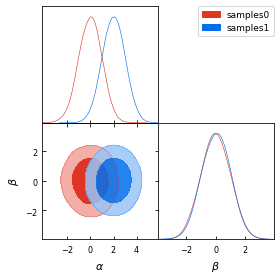

In [6]:
separation = 2

#gaussian
info1 = {
    "likelihood": {
        "gaussian_mixture": {
            "means": [0, 0],
            "covs": [[1.0, 0.0],
                     [0.0, 1.0]],
            "derived": True}},
    "params": dict([
        ("a", {
            "prior": {"min": -5, "max": 10},
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"min": -5, "max": 10},
            "ref": 0,
            "proposal": 0.5,
            "latex": r"\beta"}),
        ("derived_a", {
            "latex": r"\alpha^\prime"}),
        ("derived_b", {
            "latex": r"\beta^\prime"})]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.005, "max_tries": 1000}}}

# different gaussian
info2 = {
    "likelihood": {
        "gaussian_mixture": {
            "means": [separation, 0],
            "covs": [[1.0, 0.0],
                     [0.0, 1.0]],
            "derived": True}},
    "params": dict([
        ("a", {
            "prior": {"min": -5, "max": 10},
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"min": -5, "max": 10},
            "ref": 0,
            "proposal": 0.5,
            "latex": r"\beta"}),
        ("derived_a", {
            "latex": r"\alpha^\prime"}),
        ("derived_b", {
            "latex": r"\beta^\prime"})]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.005, "max_tries": 1000}}}

updated_info1, sampler1 = run(info1)
updated_info2, sampler2 = run(info2)

gdsamples1 = MCSamplesFromCobaya(updated_info1, sampler1.products()["sample"])
gdsamples2 = MCSamplesFromCobaya(updated_info2, sampler2.products()["sample"])
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([gdsamples1,gdsamples2], ["a", "b"], filled=True)


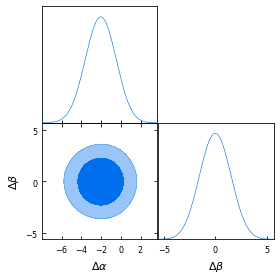

In [8]:
# get parameter difference


# separate dictionary into x,y arrays
a1 = gdsamples1['a']
b1 = gdsamples1['b']
a2 = gdsamples2['a']
b2 = gdsamples2['b']

# init difference arrays
diff_a = np.zeros([len(a1),len(a2)])
diff_b = np.zeros([len(b1),len(b2)])

# take each point in alpha and subtract each beta
for idx1 in range(len(a1)):
    for idx2 in range(len(a2)):
        diff_a[idx1][idx2] = a1[idx1]-a2[idx2]
        pass
    pass

for idx1 in range(len(b1)):
    for idx2 in range(len(b2)):
        diff_b[idx1][idx2] = b1[idx1]-b2[idx2]
        pass
    pass

# flatten to 1d
diff_a = diff_a.flatten()
diff_b = diff_b.flatten()

from getdist.mcsamples import MCSamples

# convert to MCSamples so it can be plotted with gdplot
diff = MCSamples(samples = [diff_a,diff_b],names=['da','db'], labels=['\\Delta \\alpha','\\Delta \\beta'])

results = np.stack(plt.hist2d(diff_a,diff_b,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[0])
binx=[]
biny=[]
edge_x = plt.hist2d(diff_a,diff_b,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[1]
edge_y = plt.hist2d(diff_a,diff_b,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

plt.close()
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(diff, ["da", "db"], filled=True)

In [ ]:
# Normalizing flow
class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        print("Starting training...")
        
    def on_epoch_begin(self, epoch, logs=None):
        if(epoch % 5 == 0):
            print("Begin Epoch {}...".format(epoch))

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)
        if((epoch + 1) % 5 == 0):
            print("End Epoch {}. Loss = {:5.5f}. Validation loss = {:5.5f}".format(epoch,logs['loss'],logs['val_loss']))

    def on_train_end(self, logs=None):
#        fig,ax1 = plt.subplots(1,1) #(ax1, ax2) = plt.subplots(1,2)
#        
#        ax1.set_title('loss vs. epoch')
#        ax1.set_xlabel('epoch')
#        ax1.set_ylabel('loss')
#        ax1.plot(self._epoch,self._loss)
#        
        print("Completed training!")

Starting training...
Begin Epoch 0...
End Epoch 4. Loss = 3.66396. Validation loss = 3.72646
Begin Epoch 5...
End Epoch 9. Loss = 3.66379. Validation loss = 3.72522
Completed training!


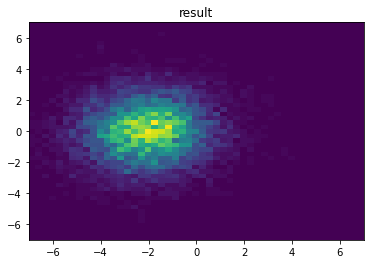

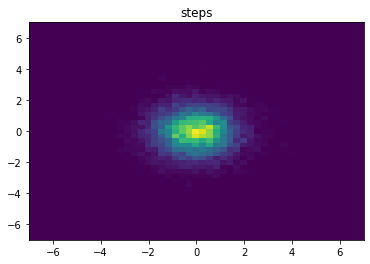

In [ ]:
def sample(n,dist):
    p = dist.sample(n)
    px = p[...,0]
    py = p[...,1]
    return (px,py,p)
    
def train(base,X,Y,n_maf,n,batch_size,permute,n_epochs):
    nsamples=n
    ## NN setup
    # Set up bijector MADE
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation=tf.math.asinh, kernel_initializer='glorot_uniform')
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(2) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        # The x direction does not want to separate, so I want to see if permuting the input can help
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
        
    target_distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(base),
        bijector=tfb.Chain(bijectors)) 

    
    # now perform the fit
    xdata = np.stack([X, Y], axis=-1)
    ydata = base.sample(nsamples)
    #print(data)
    #plt.scatter(X,Y,s=5)

    # Construct model.
    x_ = tfk.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'],
                  loss=lambda _, log_prob: -log_prob) 

    loss_plot = []
    #batch_size = 1000
    model.fit(x=xdata,
              y=np.zeros((int(2*nsamples), 2), dtype=np.float32),
              batch_size=batch_size,
              epochs=n_epochs,
              steps_per_epoch=n/(2*batch_size),  # Usually `n // batch_size`.
              validation_split=0.2,
              shuffle=True,
              verbose=False,
              callbacks=[Callback()]) #, ydata
    
    # need to create test set.
    #model.evaluate(x=xdata,y=np.zeros(int(nsamples)),callbacks=[Callback()])
    
    return(target_distribution)
    
def plot(x,y,title):
    plt.figure()
    plt.title(title)
    plt.hist2d(x,y,bins = [np.linspace(-7,7,50),np.linspace(-7,7,50)])
    
# defines the distribution we want to map to
trained_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

x = diff['da']
y = diff['db']

# train
trained_dist = train(trained_dist,x,y,n_maf=1,n=len(x),batch_size=1000,permute=False,n_epochs=10)# The result should not depend on the change of variables z1<->z2 

# plot modelled dist
tx,ty,txy=sample(10000,trained_dist)
plot(tx,ty,'result')

# plot each MADE
l_bijectors = np.array(trained_dist.bijector.bijectors)#np.flipud()
step_data=txy
for bij in l_bijectors:
    step_data = bij.inverse(step_data)
    plot(step_data[...,0],step_data[...,1],'steps')


In [ ]:
#Compute significance

prob = trained_dist.prob([0.,0.])
print(prob)

n_points = 10000
n_pass = 0

_s = trained_dist.sample(n_points)
_v = trained_dist.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1

print(n_pass/n_points)
        
n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
print(n_sigma)

tf.Tensor(0.029482579, shape=(), dtype=float32)
0.5708
0.7905613643586861


Now with one example done, lets set up multiprocessing and do the a full run.

In [ ]:

def gen_data(sep):
  ######################
  #
  # Set up distributions
  #
  ######################
  
  #gaussian
  info1 = {
      "likelihood": {
          "gaussian_mixture": {
              "means": [0, 0],
              "covs": [[1.0, 0.0],
                      [0.0, 1.0]],
              "derived": True}},
      "params": dict([
          ("a", {
              "prior": {"min": -5, "max": 10},
              "latex": r"\alpha"}),
          ("b", {
              "prior": {"min": -5, "max": 10},
              "ref": 0,
              "proposal": 0.5,
              "latex": r"\beta"}),
          ("derived_a", {
              "latex": r"\alpha^\prime"}),
          ("derived_b", {
              "latex": r"\beta^\prime"})]),
      "sampler": {
          "mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}}

  # different gaussian
  info2 = {
      "likelihood": {
          "gaussian_mixture": {
              "means": [sep, 0],
              "covs": [[1.0, 0.0],
                      [0.0, 1.0]],
              "derived": True}},
      "params": dict([
          ("a", {
              "prior": {"min": -5, "max": 10},
              "latex": r"\alpha"}),
          ("b", {
              "prior": {"min": -5, "max": 10},
              "ref": 0,
              "proposal": 0.5,
              "latex": r"\beta"}),
          ("derived_a", {
              "latex": r"\alpha^\prime"}),
          ("derived_b", {
              "latex": r"\beta^\prime"})]),
      "sampler": {
          "mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}}

  updated_info1, sampler1 = run(info1)
  updated_info2, sampler2 = run(info2)

  gdsamples1 = MCSamplesFromCobaya(updated_info1, sampler1.products()["sample"])
  gdsamples2 = MCSamplesFromCobaya(updated_info2, sampler2.products()["sample"])

  # Get difference distribution
  # separate dictionary into x,y arrays
  a1 = gdsamples1['a']
  b1 = gdsamples1['b']
  a2 = gdsamples2['a']
  b2 = gdsamples2['b']

  # init difference arrays
  diff_a = np.zeros([len(a1),len(a2)])
  diff_b = np.zeros([len(b1),len(b2)])

  # take each point in alpha and subtract each beta
  for idx1 in range(len(a1)):
      for idx2 in range(len(a2)):
          diff_a[idx1][idx2] = a1[idx1]-a2[idx2]
          pass
      pass

  for idx1 in range(len(b1)):
      for idx2 in range(len(b2)):
          diff_b[idx1][idx2] = b1[idx1]-b2[idx2]
          pass
      pass

  # flatten to 1d
  diff_a = diff_a.flatten()
  diff_b = diff_b.flatten()

  # convert to MCSamples so it can be plotted with gdplot
  diff = MCSamples(samples = [diff_a,diff_b],names=['da','db'], labels=['\\Delta \\alpha','\\Delta \\beta'])
  
  return diff

def setup_train(diff):
  ####################
  #
  # Train distribution
  #
  ####################

  # defines the distribution we want to map to
  trained_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

  x = diff['da']
  y = diff['db']

  # train
  trained_dist = train(trained_dist,x,y,n_maf=1,n=len(x),batch_size=1000,permute=False,n_epochs=5)# The result should not depend on the change of variables z1<->z2 

  return trained_dist

def significance(trained_dist):
  ######################
  #
  # Compute significance
  #
  ######################

  prob = trained_dist.prob([0.,0.])

  n_points = 10000
  n_pass = 0

  _s = trained_dist.sample(n_points)
  _v = trained_dist.prob(_s)
  for val in _v:
      if val>prob:
          n_pass+=1
          
  n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
  return n_sigma,n_pass/n_points


In [ ]:
def compute_sigvsep(sep):
    print("=========================== \n")
    print(" generating data...\n")
    print("=========================== \n")
    data = gen_data(sep)
    print("=========================== \n")
    print(" training NN...\n")
    print("=========================== \n")
    dist = setup_train(data)
    print("=========================== \n")
    print(" computing n_sigma...\n")
    print("=========================== \n")
    n_sigma = significance(dist)
    print("=========================== \n")
    print(" Done.\n")
    print("=========================== \n")
    return(n_sigma)

result_data = []
sep_arr = np.linspace(0,5,10)

for sep in sep_arr:
    result_data.append([sep,compute_sigvsep(sep)])

print(result_data)


 generating data...


[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 10300.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:5.304335, b:0
[mcmc] Sampling!
[mcmc] Progress @ 2022-04-08 19:04:19 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.221
[mcmc]  - Convergence of means: R-1 = 1.113978 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]

[0.0, (0.0015039775317651203, 0.0012)]
[0.5555555555555556, (0.1054736217688682, 0.084)]
[1.1111111111111112, (0.28388305846751494, 0.2235)]
[1.6666666666666667, (0.5777987489791598, 0.4366)]
[2.2222222222222223, (0.996309066348687, 0.6809)]
[2.7777777777777777, (1.3670807383113872, 0.8284)]
[3.3333333333333335, (1.709275118381712, 0.9126)]
[3.8888888888888893, (2.0475919376336646, 0.9594)]
[4.444444444444445, (2.4702994283625896, 0.9865)]
[5.0, (2.721430761482366, 0.9935)]


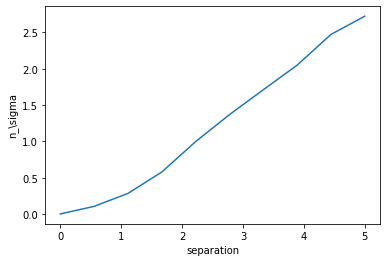

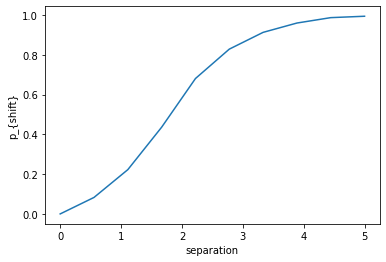

In [17]:
x = []
y = []
z = []

for i in range(len(result_data)):
    print(result_data[i])
    x.append(result_data[i][0])
    y.append(result_data[i][1][0])
    z.append(result_data[i][1][1])

plt.xlabel('separation')
plt.ylabel('n_\sigma')
plt.plot(x,y)
plt.show()
plt.xlabel('separation')
plt.ylabel('p_{shift}')
plt.plot(x,z)
plt.show()

++++++++++++++++++++++++++++++
SEPARATION = 0.0
++++++++++++++++++++++++++++++
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 7150.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:-4.61361, b:0
[mcmc] Sampling!
[mcmc] Progress @ 2022-09-30 11:52:10 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.282
[mcmc]  - Convergence of means: R-1 = 0.656888 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] 

[mcmc] Learn + convergence test @ 1040 samples accepted.
[mcmc]  - Acceptance rate: 0.322
[mcmc]  - Convergence of means: R-1 = 0.022132 after 832 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1120 samples accepted.
[mcmc]  - Acceptance rate: 0.320
[mcmc]  - Convergence of means: R-1 = 0.016747 after 896 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1200 samples accepted.
[mcmc]  - Acceptance rate: 0.319
[mcmc]  - Convergence of means: R-1 = 0.013806 after 960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1280 samples accepted.
[mcmc]  - Acceptance rate: 0.316
[mcmc]  - Convergence of means: R-1 = 0.023043 after 1024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1360 samples accepted.
[mcmc]  - Acceptance rate: 0.314
[mcmc]  - Convergence of means: R-1 = 0.016208 af

[root] Function eval 1 at point 1 has f = 0 at x = [0. 0.]
[root] Initialising (coordinate directions)
[root] Function eval 2 at point 2 has f = 0.01 at x = [0.1 0. ]
[root] Function eval 3 at point 3 has f = 0.01 at x = [0.  0.1]
[root] Function eval 4 at point 4 has f = 0.01 at x = [-0.1  0. ]
[root] Function eval 5 at point 5 has f = 0.01 at x = [ 0.  -0.1]
[root] Beginning main loop
[root] New rho = 0.01 after 5 function evaluations
[root] New rho = 0.001 after 5 function evaluations
[root] Function eval 6 at point 6 has f = 2.25e-06 at x = [0.0015 0.    ]
[root] Function eval 7 at point 7 has f = 2.25e-06 at x = [0.     0.0015]
[root] New rho = 0.0001 after 7 function evaluations
[root] Function eval 8 at point 8 has f = 2.25e-08 at x = [-0.00015  0.     ]
[root] Function eval 9 at point 9 has f = 2.25e-08 at x = [ 0.      -0.00015]
[root] New rho = 1e-05 after 9 function evaluations
[root] Function eval 10 at point 10 has f = 2.25e-10 at x = [1.5e-05 0.0e+00]
[root] Function eval

[mcmc]  - Acceptance rate: 0.300
[mcmc]  - Convergence of means: R-1 = 0.010808 after 576 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 800 samples accepted.
[mcmc]  - Acceptance rate: 0.303
[mcmc]  - Convergence of means: R-1 = 0.010738 after 640 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 880 samples accepted.
[mcmc]  - Acceptance rate: 0.305
[mcmc]  - Convergence of means: R-1 = 0.020135 after 704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 960 samples accepted.
[mcmc]  - Acceptance rate: 0.306
[mcmc]  - Convergence of means: R-1 = 0.021395 after 768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1040 samples accepted.
[mcmc]  - Acceptance rate: 0.305
[mcmc]  - Convergence of means: R-1 = 0.018012 after 832 accepted steps
[mcmc]  - Updated covariance matrix of

[root] New rho = 1e-08 after 19 function evaluations
[root] Function eval 20 at point 20 has f = 0.0625000000000002 at x = [2.50000003e-01 1.46503658e-08]
[root] Function eval 21 at point 21 has f = 0.0625000000000002 at x = [ 2.50000015e-01 -3.21978087e-09]
[root] Function eval 22 at point 22 has f = 0.0625 at x = [2.50000000e-01 7.05591149e-11]
[root] Did a total of 1 run(s)
****** Py-BOBYQA Results ******
Solution xmin = [0. 0.]
Objective value f(xmin) = 0
Needed 18 objective evaluations (at 18 points)
Approximate gradient = [0. 0.]
Approximate Hessian = [[1. 0.]
 [0. 1.]]
Exit flag = 0
Success: rho has reached rhoend
******************************

++++++++++++++++++++++++++++++
SEPARATION = 1.0
++++++++++++++++++++++++++++++
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Settin

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 880 samples accepted.
[mcmc]  - Acceptance rate: 0.315
[mcmc]  - Convergence of means: R-1 = 0.031638 after 704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 960 samples accepted.
[mcmc]  - Acceptance rate: 0.313
[mcmc]  - Convergence of means: R-1 = 0.012532 after 768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1040 samples accepted.
[mcmc]  - Acceptance rate: 0.310
[mcmc]  - Convergence of means: R-1 = 0.005937 after 832 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1120 samples accepted.
[mcmc]  - Acceptance rate: 0.310
[mcmc]  - Convergence of means: R-1 = 0.010974 after 896 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1200 samples accepted.
[mcmc]  - Acceptance rate: 0.305

[root] Function eval 16 at point 16 has f = 0.25000000000225 at x = [5.00000476e-01 1.42261472e-06]
[root] Function eval 17 at point 17 has f = 0.25000000000225 at x = [ 5.00001423e-01 -4.75547349e-07]
[root] New rho = 1e-07 after 17 function evaluations
[root] Function eval 18 at point 18 has f = 0.250000000000023 at x = [4.99999858e-01 4.75548081e-08]
[root] Function eval 19 at point 19 has f = 0.250000000000023 at x = [ 4.99999952e-01 -1.42262226e-07]
[root] New rho = 1e-08 after 19 function evaluations
[root] Function eval 20 at point 20 has f = 0.25 at x = [5.00000005e-01 1.42262226e-08]
[root] Function eval 21 at point 21 has f = 0.25 at x = [ 5.00000014e-01 -4.75548012e-09]
[root] Function eval 22 at point 22 has f = 0.25 at x = [ 4.99999995e-01 -1.42262225e-08]
[root] Function eval 23 at point 23 has f = 0.25 at x = [ 5.00000000e-01 -3.19875167e-11]
[root] Did a total of 1 run(s)
****** Py-BOBYQA Results ******
Solution xmin = [0. 0.]
Objective value f(xmin) = 0
Needed 18 objec

[mcmc]  - Convergence of means: R-1 = 0.024115 after 704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 960 samples accepted.
[mcmc]  - Acceptance rate: 0.301
[mcmc]  - Convergence of means: R-1 = 0.021320 after 768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1040 samples accepted.
[mcmc]  - Acceptance rate: 0.291
[mcmc]  - Convergence of means: R-1 = 0.027282 after 832 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1120 samples accepted.
[mcmc]  - Acceptance rate: 0.297
[mcmc]  - Convergence of means: R-1 = 0.021788 after 896 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1200 samples accepted.
[mcmc]  - Acceptance rate: 0.290
[mcmc]  - Convergence of means: R-1 = 0.019294 after 960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + c

[root] Function eval 14 at point 14 has f = 0.5625000225 at x = [ 7.50138892e-01 -5.66477255e-05]
[root] New rho = 1e-05 after 14 function evaluations
[root] Function eval 15 at point 15 has f = 0.562500000225 at x = [7.49986661e-01 6.86084246e-06]
[root] Function eval 16 at point 16 has f = 0.562500000225 at x = [ 7.49993223e-01 -1.33817081e-05]
[root] New rho = 1e-06 after 16 function evaluations
[root] Function eval 17 at point 17 has f = 0.56250000000225 at x = [7.50000670e-01 1.34197745e-06]
[root] Function eval 18 at point 18 has f = 0.56250000000225 at x = [ 7.50001342e-01 -6.70737897e-07]
[root] New rho = 1e-07 after 18 function evaluations
[root] Function eval 19 at point 19 has f = 0.562500000000022 at x = [ 7.49999933e-01 -1.34099643e-07]
[root] Function eval 20 at point 20 has f = 0.562500000000023 at x = [7.49999866e-01 6.71925749e-08]
[root] New rho = 1e-08 after 20 function evaluations
[root] Function eval 21 at point 21 has f = 0.5625 at x = [7.50000007e-01 1.34114082e-

[mcmc]  - Convergence of means: R-1 = 0.325882 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.277
[mcmc]  - Convergence of means: R-1 = 0.243188 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.288
[mcmc]  - Convergence of means: R-1 = 0.114629 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 0.296
[mcmc]  - Convergence of means: R-1 = 0.039873 after 320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.285
[mcmc]  - Convergence of means: R-1 = 0.062399 after 384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + conv

[root] Function eval 7 at point 7 has f = 1.16 at x = [6.00000000e-01 2.28212511e-17]
[root] Function eval 8 at point 8 has f = 1 at x = [1.00000000e+00 5.17663513e-17]
[root] Function eval 9 at point 9 has f = 1.0121 at x = [1.11000000e+00 1.93995635e-16]
[root] Function eval 10 at point 10 has f = 1.0101 at x = [1.         0.10049876]
[root] New rho = 0.01 after 10 function evaluations
[root] Function eval 11 at point 11 has f = 1.000225 at x = [ 0.99208446 -0.01274144]
[root] Function eval 12 at point 12 has f = 1.000225 at x = [0.9861761  0.00582235]
[root] New rho = 0.001 after 12 function evaluations
[root] Function eval 13 at point 13 has f = 1.00000225 at x = [ 1.00146143e+00 -3.37979930e-04]
[root] Function eval 14 at point 14 has f = 1.00000225 at x = [1.00037362 0.00145272]
[root] New rho = 0.0001 after 14 function evaluations
[root] Function eval 15 at point 15 has f = 1.0000000225 at x = [9.99856206e-01 4.27000076e-05]
[root] Function eval 16 at point 16 has f = 1.00000002

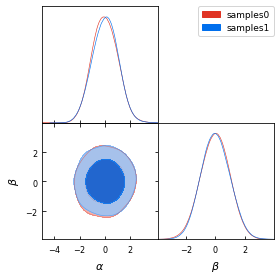

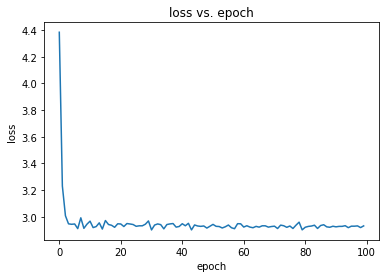

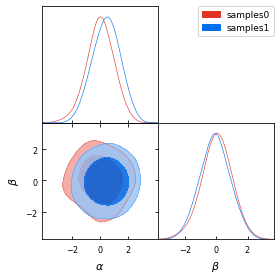

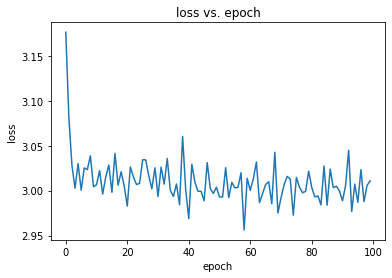

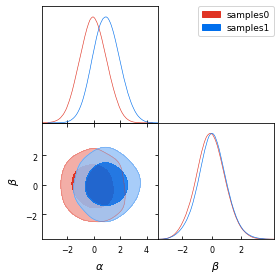

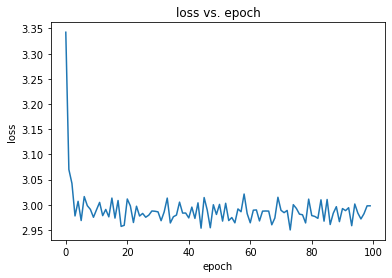

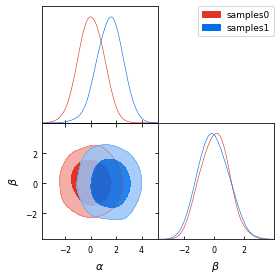

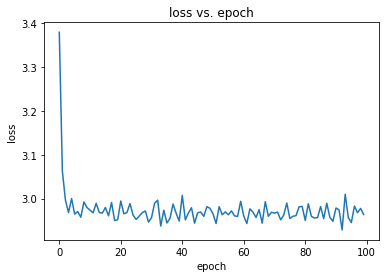

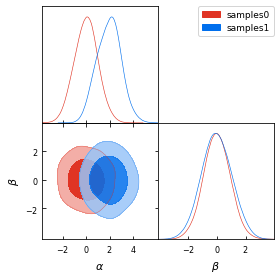

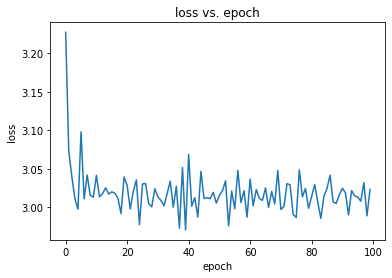

In [60]:

def gen_data(sep):
    ######################
    #
    # Set up distributions
    #
    ######################

    #gaussian
    info1 = {
      "likelihood": {
          "gaussian_mixture": {
              "means": [0, 0],
              "covs": [[1.0, 0.0],
                      [0.0, 1.0]],
              "derived": True}},
      "params": dict([
          ("a", {
              "prior": {"min": -5, "max": 10},
              "latex": r"\alpha"}),
          ("b", {
              "prior": {"min": -5, "max": 10},
              "ref": 0,
              "proposal": 0.5,
              "latex": r"\beta"}),
          ("derived_a", {
              "latex": r"\alpha^\prime"}),
          ("derived_b", {
              "latex": r"\beta^\prime"})]),
      "sampler": {
          "mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}
    }

    # different gaussian
    info2 = {
      "likelihood": {
          "gaussian_mixture": {
              "means": [sep, 0],
              "covs": [[1.0, 0.0],
                      [0.0, 1.0]],
              "derived": True}},
      "params": dict([
          ("a", {
              "prior": {"min": -5, "max": 10},
              "latex": r"\alpha"}),
          ("b", {
              "prior": {"min": -5, "max": 10},
              "ref": 0,
              "proposal": 0.5,
              "latex": r"\beta"}),
          ("derived_a", {
              "latex": r"\alpha^\prime"}),
          ("derived_b", {
              "latex": r"\beta^\prime"})]),
      "sampler": {
          "mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}
    }
    


    updated_info1, sampler1 = run(info1)
    updated_info2, sampler2 = run(info2)
    #updated_info3, sampler3 = run(info3)
    
    gdsamples1 = MCSamplesFromCobaya(updated_info1, sampler1.products()["sample"])
    gdsamples2 = MCSamplesFromCobaya(updated_info2, sampler2.products()["sample"])
    #gdsamples3 = MCSamplesFromCobaya(updated_info3, sampler3.products()["sample"])
    
    gdplot = gdplt.get_subplot_plotter()
    gdplot.triangle_plot([gdsamples1,gdsamples2],['a','b'],filled=True)#,gdsamples3, filled=True)

    return gdsamples1,gdsamples2
    
def nf(chain1,chain2):
    chains = diff.chain()
    chains.chains = [chain1,chain2]
    chains.diff()
    maf = flow.MAF(2)
    maf.setup()
    maf.train(chains.diff_chain,batch_size=100,feedback=True)
    nsigma,high,low = tension.flow_significance(
                        maf.target_dist,
                        maf.gauss_bijector,
                        len(chains.params)
                        )
    return nsigma

def lkl(x,cov=np.diag([1,1])):
    dx = np.array(x-mean)
    cov = np.array(cov)
    log_lkl = -0.5*( dx.T @ cov @ dx )
    return -1*log_lkl

def lkl0(x,cov=np.diag([1,1])):
    dx = np.array(x)
    cov = np.array(cov)
    log_lkl = -0.5*( dx.T @ cov @ dx )
    return -1*log_lkl

def lklab(x,cov=np.diag([1,1])):
    return lkl0(x)+lkl(x)
results = []
for sep in range(5):
    print('++++++++++++++++++++++++++++++')
    print('SEPARATION = '+str(sep/2))
    print('++++++++++++++++++++++++++++++')
    
    chain1,chain2 = gen_data(sep/2)
        
    nsigma1 = nf(chain1,chain2) 
    
    bounds = np.array([[-10,-5],[10,5]])

    map_a =  pybobyqa.solve(lkl0,
                            [0,0],
                            maxfun=100,
                            bounds=bounds,
                           )
    
    mean = [sep/2,0]
    map_b = pybobyqa.solve(lkl,
                            [0,0],
                            maxfun=100,
                            bounds=bounds,
                           )
    
    map_ab = pybobyqa.solve(lklab,
                            [0,0],
                            maxfun=500,
                           )
    print(map_a)
    
    Q_DMAP = map_ab.f - map_a.f - map_b.f
    d=2
    
    pte = scipy.stats.chi2.cdf(Q_DMAP, d)
    nsigma2 = np.sqrt(2)*scipy.special.erfinv(pte)
    
    results.append([sep,nsigma1,nsigma2])
print(results)

In [61]:
print(results)

[[0, 0.0007519885532624763, 0.0], [1, 0.052362316476192654, 0.03856998312142628], [2, 0.22091322467686078, 0.14780469674944446], [3, 0.48338837616133823, 0.3122643881054401], [4, 0.7216007140874545, 0.5150319988122171]]


[0, 0.0007519885532624763, 0.0]
[1, 0.052362316476192654, 0.03856998312142628]
[2, 0.22091322467686078, 0.14780469674944446]
[3, 0.48338837616133823, 0.3122643881054401]
[4, 0.7216007140874545, 0.5150319988122171]


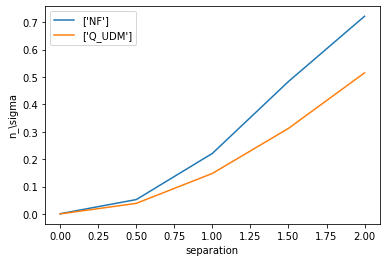

In [65]:
x = []
y = []
z = []

for i in range(len(results)):
    print(results[i])
    x.append(results[i][0]/2)
    y.append(results[i][1])
    z.append(results[i][2])

plt.xlabel('separation')
plt.ylabel('n_\sigma')
plt.plot(x,y,label=['NF'])
plt.plot(x,z,label=['Q_UDM'])
plt.legend()
plt.show()